### Script to acquire ICESat-2 data into your Pangeo workspace for initial tutorial development

* Scott Henderson, Anthony Arendt, David Shean, University of Washington

In [1]:
%matplotlib inline
import os
import s3fs
import xarray as xr
import h5py
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import fiona
import cartopy.crs as ccrs
from mpl_toolkits.mplot3d import Axes3D

## Connect to S3 bucket containing sample ICESat-2 data

In [2]:
bucket = 'pangeo-data-upload-oregon'
fs = s3fs.S3FileSystem()

## List contents of the bucket

In [18]:
dataDir = 'pangeo-data-upload-oregon/icesat2/atl06'
s3List = fs.ls(dataDir)
print(s3List)

['pangeo-data-upload-oregon/icesat2/atl06/ATL06_20181014113520_02420106_205_01.h5', 'pangeo-data-upload-oregon/icesat2/atl06/ATL06_20181017101822_02870106_205_01.h5', 'pangeo-data-upload-oregon/icesat2/atl06/ATL06_20181019051247_03140110_203_01.h5']


## Pick some data to work with
In this case, the first file contains data over Mt. Rainier

In [20]:
s3File = s3List[0]
dataFile = format(s3File.split('/')[3])

## Download an HDF5 to home directory
Data will be in your git directory. Be sure to .gitignore .h5 files so they are not pushed to GitHub.

In [21]:
fs.get(s3File, dataFile)

### Using h5py to look at the dataset structure

ICESat-2 data are structured in h5 files with multiple group levels. To find what you need it helps to view these groups. 

In [22]:
f = h5py.File(dataFile,'r')

In [23]:
printGroups = True
groups = list(f.keys())
for g in groups:
    group = f[g]
    if printGroups:
        print('---')
        print('Group: {}'.format(g))
        print('---')
        for d in group.keys():
            print(group[d])

---
Group: METADATA
---
<HDF5 group "/METADATA/AcquisitionInformation" (4 members)>
<HDF5 group "/METADATA/DataQuality" (2 members)>
<HDF5 group "/METADATA/DatasetIdentification" (0 members)>
<HDF5 group "/METADATA/Extent" (0 members)>
<HDF5 group "/METADATA/Lineage" (13 members)>
<HDF5 group "/METADATA/ProcessStep" (4 members)>
<HDF5 group "/METADATA/ProductSpecificationDocument" (0 members)>
<HDF5 group "/METADATA/QADatasetIdentification" (0 members)>
<HDF5 group "/METADATA/SeriesIdentification" (0 members)>
---
Group: ancillary_data
---
<HDF5 dataset "atlas_sdp_gps_epoch": shape (1,), type "<f8">
<HDF5 dataset "control": shape (1,), type "|S10000">
<HDF5 dataset "data_end_utc": shape (1,), type "|S27">
<HDF5 dataset "data_start_utc": shape (1,), type "|S27">
<HDF5 dataset "end_cycle": shape (1,), type "<i4">
<HDF5 dataset "end_delta_time": shape (1,), type "<f8">
<HDF5 dataset "end_geoseg": shape (1,), type "<i4">
<HDF5 dataset "end_gpssow": shape (1,), type "<f8">
<HDF5 dataset "en

In [24]:
f.close()

### Open the data using xarray

From above we decided to work with gt3r/land_ice_segments.

Xarray provides simple tools for accessing the data.

In [25]:
ds = xr.open_dataset(dataFile,group='/gt3r/land_ice_segments')
print(ds)

<xarray.Dataset>
Dimensions:                (delta_time: 114193)
Coordinates:
  * delta_time             (delta_time) datetime64[ns] 2018-10-14T11:35:20.653233164 ... 2018-10-14T11:42:23.401819260
    latitude               (delta_time) float64 ...
    longitude              (delta_time) float64 ...
Data variables:
    atl06_quality_summary  (delta_time) int8 ...
    h_li                   (delta_time) float32 ...
    h_li_sigma             (delta_time) float32 ...
    segment_id             (delta_time) float64 ...
    sigma_geo_h            (delta_time) float32 ...
Attributes:
    Description:  The land_ice_height group contains the primary set of deriv...
    data_rate:    Data within this group are sparse.  Data values are provide...


### Convert to Pandas dataframe

In [26]:
df = ds.to_dataframe()
df.head()

,atl06_quality_summary,h_li,h_li_sigma,latitude,longitude,segment_id,sigma_geo_h
delta_time,,,,,,,
2018-10-14 11:35:20.653233164,1,327.243286,0.653657,59.502253,-116.951166,671085.0,0.057640
2018-10-14 11:35:20.656065164,1,325.670044,1.047462,59.502075,-116.951202,671086.0,0.024585
2018-10-14 11:35:20.667385872,1,327.828369,2.733043,59.501360,-116.951347,671090.0,0.021911
2018-10-14 11:35:20.670206308,1,329.161957,1.432616,59.501181,-116.951383,671091.0,0.021599
2018-10-14 11:35:20.673025584,1,326.039276,0.412333,59.501002,-116.951419,671092.0,0.021670


## Make a simple 3D scatter plot

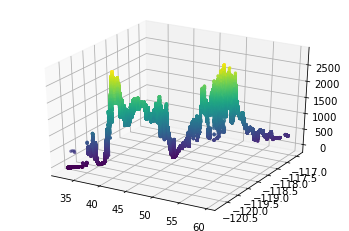

In [27]:
f = plt.figure()
ax3D = f.add_subplot(111, projection='3d')
sc = ax3D.scatter(df['latitude'], df['longitude'], df['h_li'], c=df['h_li'], marker='.')

## Convert the Pandas dataframe to a Geopandas dataframe

This mean the latitude and longitude columns are converted from just numbers into a geometry so Python knows where the data are in space.

In [28]:
df['geometry'] = list(zip(df['longitude'], df['latitude']))
df['geometry'] = df['geometry'].apply(Point)
gdf = gpd.GeoDataFrame(df)
df.head()

,atl06_quality_summary,h_li,h_li_sigma,latitude,longitude,segment_id,sigma_geo_h,geometry
delta_time,,,,,,,,
2018-10-14 11:35:20.653233164,1,327.243286,0.653657,59.502253,-116.951166,671085.0,0.057640,POINT (-116.9511655451136 59.50225349899778)
2018-10-14 11:35:20.656065164,1,325.670044,1.047462,59.502075,-116.951202,671086.0,0.024585,POINT (-116.9512017593071 59.50207472236904)
2018-10-14 11:35:20.667385872,1,327.828369,2.733043,59.501360,-116.951347,671090.0,0.021911,POINT (-116.9513470237097 59.5013596369711)
2018-10-14 11:35:20.670206308,1,329.161957,1.432616,59.501181,-116.951383,671091.0,0.021599,POINT (-116.9513831494835 59.50118085567001)
2018-10-14 11:35:20.673025584,1,326.039276,0.412333,59.501002,-116.951419,671092.0,0.021670,POINT (-116.9514194251804 59.50100208192521)


### make a simple map

* get a geojson file with US state polygons
* use Cartopy to make a very simple map

In [29]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

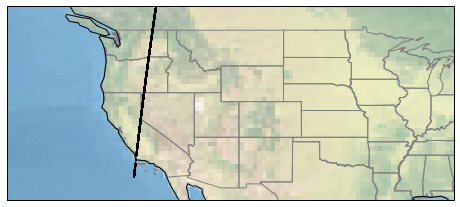

In [32]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-135,-85, 30, 49])
ax.stock_img()
states_gdf.plot(ax=ax, facecolor='none', edgecolor='gray')
gdf.plot(ax=ax, column='h_li', cmap='inferno', markersize=.5)
ax.coastlines()